In [139]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D,BatchNormalization, ZeroPadding2D, Activation
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, VGG19, InceptionResNetV2, EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [17]:
data_folder = '/content/drive/MyDrive/Colab Notebooks/project/data/Garbage classification'
image_size = (256, 256) 

labels = os.listdir(data_folder) ; labels

['plastic', 'metal', 'glass', 'cardboard', 'trash', 'paper']

In [28]:
for label in labels:
    directory = os.path.join(data_folder, label)
    print(label, " ->\t", len(os.listdir(directory)))

plastic  ->	 482
metal  ->	 410
glass  ->	 501
cardboard  ->	 403
trash  ->	 137
paper  ->	 594


In [5]:
directory = os.path.join(data_folder, 'cardboard')
path = os.path.join(directory, os.listdir(directory)[0])
image = mpimg.imread(path)
image.shape

(384, 512, 3)

In [10]:
# 이미지 파일 로딩 후 array로 변환
 
def preprocess_img(img_path, target_size=128):
  from keras.preprocessing import image
  
  # 이미지 불러오기
  img = image.load_img(img_path, target_size=(target_size, target_size))
  img_tensor = image.img_to_array(img)
  
  # 차원 expand
  img_tensor = np.expand_dims(img_tensor, axis=0)

  # 0과 1 사이로 scaling
  img_tensor /= 255.

  return img_tensor

In [13]:
# 이미지 시각화 - plastic, metal, glass, cardboard, trash, paper 순
# 행, 열
n_col = 6
n_row = 6

# 이미지 plot 크기, margin 사이즈
target_size = 128
margin = 3

# 결과를 저장할 빈 행렬
total = np.zeros((n_row * target_size + (n_row - 1) * margin, n_col * target_size + (n_col - 1) * margin, 3))

# 이미지 tensor를 'total matrix'에 append하기
img_seq = 1

for i in range(n_row):
  directory = os.path.join(data_folder, labels[i])
  
  for j in range(n_col):
    fname = labels[i]+'{}.jpg'.format(img_seq)
    img_path = os.path.join(directory, fname)

    img_tensor = preprocess_img(img_path, target_size)

    horizontal_start = i * target_size + i * margin
    horizontal_end = horizontal_start + target_size
    vertical_start = j * target_size + j * margin
    vertical_end = vertical_start + target_size

    total[horizontal_start : horizontal_end, vertical_start : vertical_end, :] = img_tensor[0]
    img_seq += 1

# grid 안에 이미지 표시하기    
plt.figure(figsize=(200, 200))
plt.imshow(total)
plt.show()

In [50]:
# 데이터 train, test, validation set으로 분류
# 각 라벨별 폴더명 모으기
label_folder = []

for label in ('glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash'):
    label_folder.append(os.path.join(data_folder, label) +'/')

In [54]:
# 파일 불러와 파일명, 라벨, 폴더, 경로 정리하기
def load_csv(subset):
 
    if subset == 'train':
        fname = data_folder + '/one-indexed-files-notrash_train.txt'
    elif subset == 'validation':
        fname = data_folder + '/one-indexed-files-notrash_val.txt'
    elif subset == 'test':
        fname = data_folder + '/one-indexed-files-notrash_test.txt'

    df = pd.read_csv(fname, sep=' ', names=['file', 'label'])

    df['label'] -= 1

    df['folder'] = [label_folder[i] for i in df['label']]
    df['path'] = df['folder'] + df['file']
    df['label'] = df['label'].astype(str)
    
    return df

In [55]:
# 데이터프레임으로 정리
df_train = load_csv('train')
df_valid = load_csv('validation')
df_test = load_csv('test')

df_train.head()

,file,label,folder,path
0,cardboard202.jpg,2,/content/drive/MyDrive/Colab Notebooks/project...,/content/drive/MyDrive/Colab Notebooks/project...
1,paper472.jpg,1,/content/drive/MyDrive/Colab Notebooks/project...,/content/drive/MyDrive/Colab Notebooks/project...
2,paper522.jpg,1,/content/drive/MyDrive/Colab Notebooks/project...,/content/drive/MyDrive/Colab Notebooks/project...
3,glass189.jpg,0,/content/drive/MyDrive/Colab Notebooks/project...,/content/drive/MyDrive/Colab Notebooks/project...
4,glass325.jpg,0,/content/drive/MyDrive/Colab Notebooks/project...,/content/drive/MyDrive/Colab Notebooks/project...


Train, Validation, Test dataset 분포는 다음과 같습니다.


In [108]:
print('train: ', len(df_train))
print('valid: ', len(df_valid))
print('test: ', len(df_test))

train:  1768
valid:  328
test:  431


### 이미지 증강

In [123]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.1,
                                   rotation_range = 0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

valid_test_datagen = ImageDataGenerator(rescale=1./255) 

In [125]:
# flow_from_dataframe으로 train, test, validation 데이터 배치를 생성
# └train, test, validation set 별로 만들어놓은 데이터프레임을 활용 
train_gen = train_datagen.flow_from_dataframe(df_train, 
                                              x_col = 'path',
                                              y_col = 'label',
                                              target_size = image_size,
                                              batch_size = 32, 
                                              class_mode = 'sparse',
                                              shuffle = True)

valid_gen = valid_test_datagen.flow_from_dataframe(df_valid, 
                                                    x_col = 'path',
                                                    y_col = 'label',
                                                    target_size = image_size,
                                                    batch_size = 32, 
                                                    class_mode = 'sparse',
                                                    shuffle = False)

test_gen = valid_test_datagen.flow_from_dataframe(df_test,
                                                    x_col = 'path',
                                                    y_col = 'label',
                                                    target_size = image_size,
                                                    batch_size = 32, 
                                                    class_mode = 'sparse',
                                                    shuffle = False)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.
Found 431 validated image filenames belonging to 6 classes.


In [126]:
# 이미지, 라벨 데이터 크기
for data1, label1 in train_gen:
    print('배치 데이터 크기:', data1.shape)
    print('배치 레이블 크기:', label1.shape)
    break

배치 데이터 크기: (32, 256, 256, 3)
배치 레이블 크기: (32,)


### 클래스 가중치 조절

Text(0, 0.5, 'population')

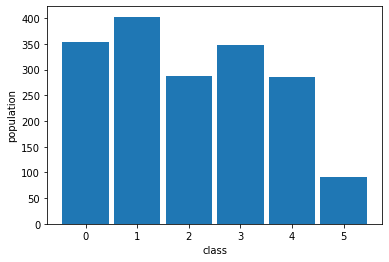

In [127]:
plt.hist(df_train['label'], bins=np.arange(7)-0.5, rwidth=0.9)
plt.xlabel('class')
plt.ylabel('population')

=> 클래스 가중치는 population에 반비례

Text(0, 0.5, 'Class weight')

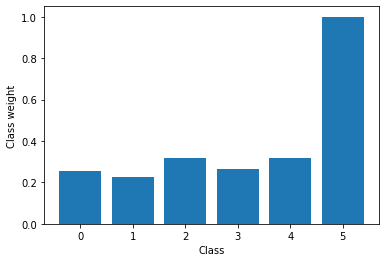

In [128]:
hist, _ = np.histogram(df_train['label'].astype(float), bins=np.arange(7)-0.5)
class_weight = hist.min()/hist
class_weight = {i:class_weight[i] for i in range(6)}

plt.bar(np.arange(6), [class_weight[i] for i in range(6)])
plt.xlabel('Class')
plt.ylabel('Class weight')

## 모델링

### 1) CNN 모델

In [129]:
# CNN 모델 - 5개의 Conv 층

# 이미지 크기
SIZE = 256
# input 크기
input_shape = (SIZE, SIZE, 3)
# 라벨 개수
n_classes = 6

def basic_cnn_model():
    
    input_tensor = Input(shape=input_shape)
    
    # Entry block
    x = Conv2D(32, kernel_size=(2, 2), activation='relu')(input_tensor)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, 2)(x)

    x = Conv2D(64, kernel_size=(2, 2), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, 2)(x)

    x = Conv2D(64, kernel_size=(2, 2), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, 2)(x)

    x = Conv2D(128, kernel_size=(2, 2), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, 2)(x)
    
    x = Conv2D(256, kernel_size=(3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2,2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)

    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=predictions)

    return model

In [130]:
# 모델 요약
basic_cnn_model = basic_cnn_model()
basic_cnn_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 255, 255, 32)      416       
                                                                 
 batch_normalization_21 (Bat  (None, 255, 255, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 126, 126, 64)      8256      
                                                                 
 batch_normalization_22 (Bat  (None, 126, 126, 64)     256 

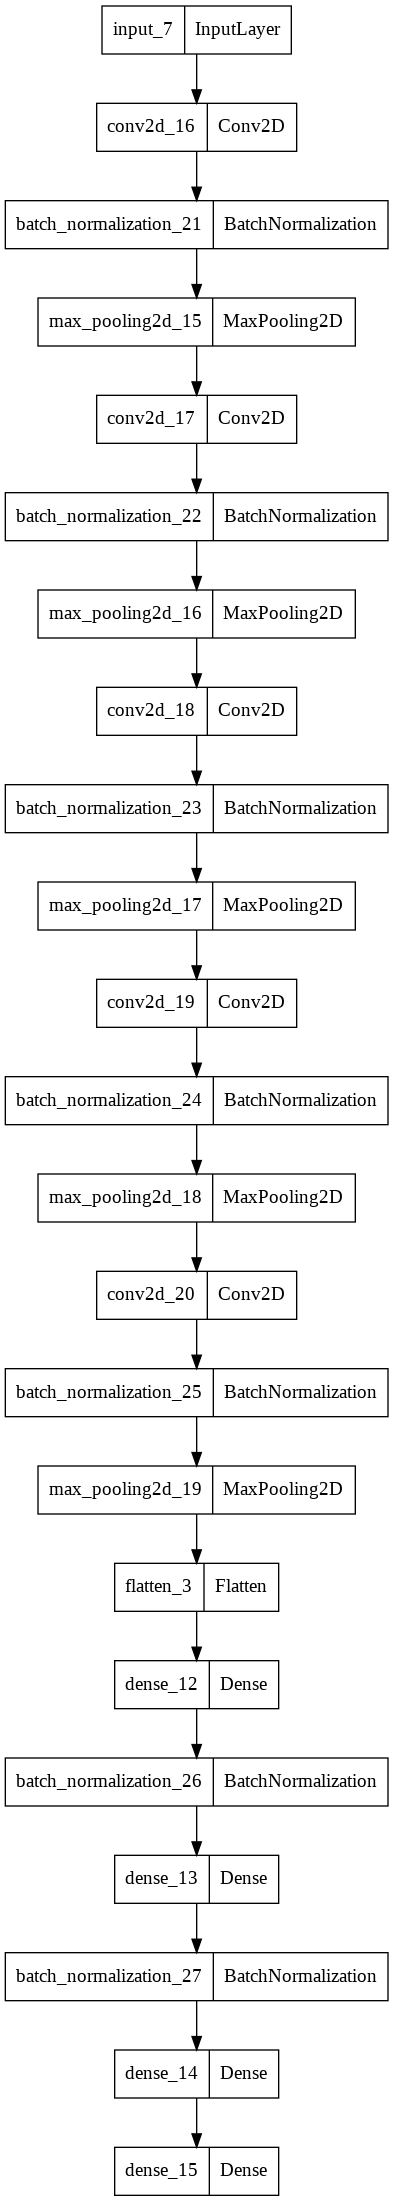

In [142]:
# 모델 구조 표현
from tensorflow.keras.utils import plot_model

plot_model(basic_cnn_model, to_file='basic_cnn_model.png')

In [131]:
# loss function은 sparse_categorical_crossentropy 기준 / optimizer는 아담, 정확도를 기준으로 모델을 설정
# val_loss를 기준으로 early stopping을 설정

basic_cnn_model.compile(loss = 'sparse_categorical_crossentropy',
                        optimizer = 'adam',
                        metrics = ['accuracy'])

callbacks = [EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
            ReduceLROnPlateau(patience=3, verbose=1),
            ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/project/basic_cnn_model.h5', verbose=1, save_best_only=True)]

In [132]:
# 모델 학습
# 클래스 가중치와 epoch 40

history = basic_cnn_model.fit(train_gen,
                              validation_data = valid_gen,
                              epochs = 40, 
                              verbose = 1,
                              class_weight = class_weight,
                              callbacks = callbacks)

Epoch 1/40
56/56 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.4802
Epoch 00001: val_loss improved from inf to 2.24769, saving model to /content/drive/MyDrive/Colab Notebooks/project/basic_cnn_model.h5
56/56 [==============================] - 273s 5s/step - loss: 0.4449 - accuracy: 0.4802 - val_loss: 2.2477 - val_accuracy: 0.1860 - lr: 0.0010
Epoch 2/40
56/56 [==============================] - ETA: 0s - loss: 0.3403 - accuracy: 0.5899
Epoch 00002: val_loss did not improve from 2.24769
56/56 [==============================] - 234s 4s/step - loss: 0.3403 - accuracy: 0.5899 - val_loss: 2.4388 - val_accuracy: 0.2530 - lr: 0.0010
Epoch 3/40
56/56 [==============================] - ETA: 0s - loss: 0.3194 - accuracy: 0.6193
Epoch 00003: val_loss did not improve from 2.24769
56/56 [==============================] - 234s 4s/step - loss: 0.3194 - accuracy: 0.6193 - val_loss: 2.9121 - val_accuracy: 0.1860 - lr: 0.0010
Epoch 4/40
56/56 [==============================] - E

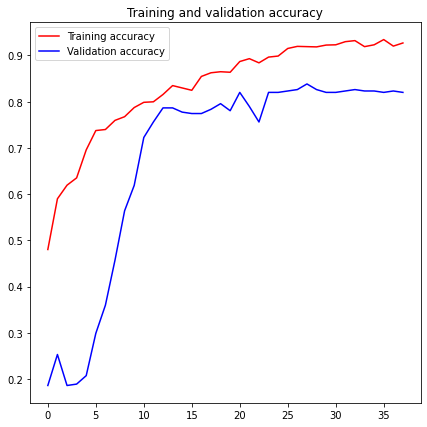

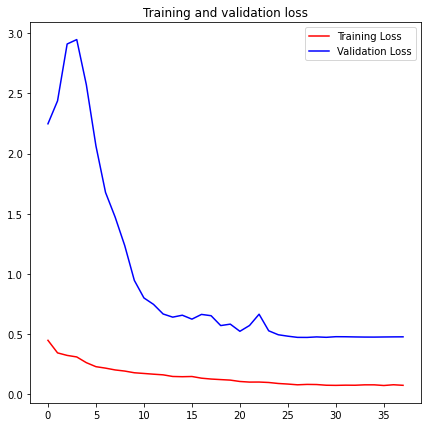

In [133]:
# 학습 결과 시각화 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(7,7))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(7,7))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

=> overfitting 없이 accuracy가 일정하게 상승, loss 하락

In [134]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

Y_pred = basic_cnn_model.predict(test_gen) # test dataset을 cnn 모델에 예측
Y_train_pred = np.argmax(Y_pred, axis=1) # argmax를 취해줌

In [135]:
# confusion matrix 결과 + classification report 결과
print('     Confusion Matrix ')
print('')
print(confusion_matrix(test_gen.classes, Y_train_pred, labels=np.unique(test_gen.classes)))
print('')
print('\t\t\tClassification Report ')
print('')
print(classification_report(test_gen.classes, Y_train_pred, zero_division=1))

     Confusion Matrix 

[[60  2  1 10  8  1]
 [ 1 94  3  6  1  3]
 [ 0  4 61  4  1  0]
 [ 4  7  4 56  2  1]
 [ 1  6  3  2 55  1]
 [ 2  3  0  1  1 22]]

			Classification Report 

              precision    recall  f1-score   support

           0       0.88      0.73      0.80        82
           1       0.81      0.87      0.84       108
           2       0.85      0.87      0.86        70
           3       0.71      0.76      0.73        74
           4       0.81      0.81      0.81        68
           5       0.79      0.76      0.77        29

    accuracy                           0.81       431
   macro avg       0.81      0.80      0.80       431
weighted avg       0.81      0.81      0.81       431



In [136]:
# 모델이 test set을 어떻게 예측하는지 확인하기 위한 시각화 함수
def plot_cm(y_true, y_pred, title, classes):
    '''
    Fancy confusion matrix plot.
    '''
    y_pred = y_pred.astype(int)
    
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    
    cm = pd.DataFrame(cm, index=classes, columns=classes)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig, ax = plt.subplots()
    plt.title(title)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)

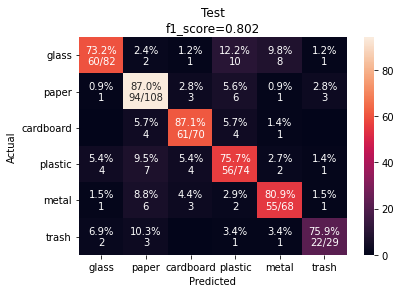

In [140]:
classes = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']

score_test = f1_score(df_test['label'].astype(int), Y_train_pred, average='macro')
plot_cm(df_test['label'].astype(int), Y_train_pred, 'Test\nf1_score=' + str('%.3f' %score_test), classes)

### 2) EfficientNet 모델

대용량 이미지넷 데이터셋을 이용해 pre-training한 모델 중 EfficientNet 모델로 학습을 시도
모델을 불러야 layer를 추가하는 방식으로 fine-tuning 진행

* Pre-trained: 기존 큰 데이터 셋에 학습된 모델을 기반으로 architecture를 새로운 목적(나의 이미지 데이터)에 맞게 변형하고 이미 학습된 모델 Weights로부터 학습을 업데이트하는 방법

In [ ]:
# EfficientNet 모델
def EfficientNet():

    base_model = EfficientNetB0(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)   

    input_tensor = Input(shape=input_shape)
    
    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
    x = Conv2D(64, kernel_size=(2,2), activation='relu')(x)
    x = MaxPooling2D(2,2)(x)
    x = Conv2D(128, kernel_size=(2,2), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)

    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=predictions)

    return model

In [ ]:
# 모델 요약
EfficientNet = EfficientNet()
EfficientNet.summary()

Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 batch_normalization_9 (Batc  (None, 256, 256, 3)      12        
 hNormalization)                                                 
                                                                 
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 64)          327744    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 128)         328

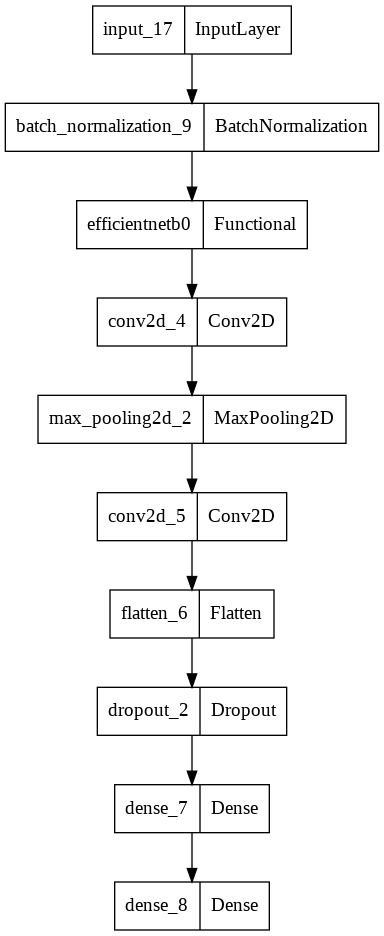

In [ ]:
plot_model(EfficientNet, to_file='EfficientNet.png')

In [ ]:
# 모델 학습
EfficientNet.compile(loss = 'sparse_categorical_crossentropy',
                        optimizer = 'adam',
                        metrics = ['accuracy'])

callbacks = [EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
            ReduceLROnPlateau(patience=3, verbose=1),
            ModelCheckpoint('/content/drive/MyDrive/__Python Code__/project/EfficientNet.h5', verbose=1, save_best_only=True)]

In [ ]:
batch_size = 32

history = EfficientNet.fit(train_gen,
                           validation_data = valid_gen,
                           epochs = 30, 
                           verbose = 1,
                           class_weight = class_weight,
                           callbacks = callbacks)

Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 0.4646 - accuracy: 0.4197
Epoch 00001: val_loss improved from inf to 1.99601, saving model to /content/drive/MyDrive/__Python Code__/project/EfficientNet.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



56/56 [==============================] - 64s 944ms/step - loss: 0.4646 - accuracy: 0.4197 - val_loss: 1.9960 - val_accuracy: 0.1982 - lr: 0.0010
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.6465
Epoch 00002: val_loss improved from 1.99601 to 1.79921, saving model to /content/drive/MyDrive/__Python Code__/project/EfficientNet.h5
56/56 [==============================] - 51s 911ms/step - loss: 0.2917 - accuracy: 0.6465 - val_loss: 1.7992 - val_accuracy: 0.1982 - lr: 0.0010
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 0.2569 - accuracy: 0.7183
Epoch 00003: val_loss did not improve from 1.79921
56/56 [==============================] - 49s 864ms/step - loss: 0.2569 - accuracy: 0.7183 - val_loss: 4.2067 - val_accuracy: 0.1402 - lr: 0.0010
Epoch 4/30
56/56 [==============================] - ETA: 0s - loss: 0.2100 - accuracy: 0.7704
Epoch 00004: val_loss did not improve from 1.79921
56/56 [==============================] - 49s 8

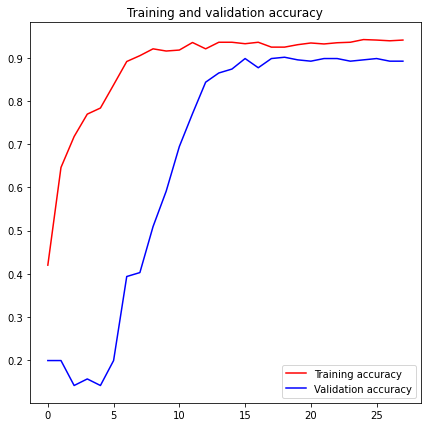

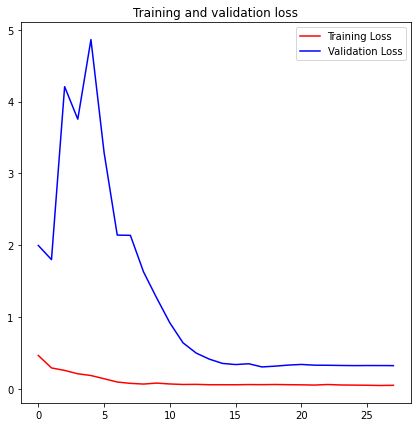

In [ ]:
# 모델 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(7,7))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(7,7))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

=> overfitting 없이 accuracy가 일정하게 상승, loss 하락

In [ ]:
Y_pred = EfficientNet.predict(test_gen) # test dataset을 cnn 모델에 예측
Y_train_pred = np.argmax(Y_pred, axis=1) # argmax를 취해줌

In [ ]:
# confusion matrix 결과 + classification report 결과

print('     Confusion Matrix ')
print('')
print(confusion_matrix(test_gen.classes, Y_train_pred, labels=np.unique(test_gen.classes)))
print('')
print('\t\t\tClassification Report ')
print('')
print(classification_report(test_gen.classes, Y_train_pred, zero_division=1))

     Confusion Matrix 

[[71  1  0  4  6  0]
 [ 0 94  3  3  1  7]
 [ 0  3 65  1  1  0]
 [ 3  1  0 68  0  2]
 [ 1  0  1  2 64  0]
 [ 0  2  0  1  0 26]]

			Classification Report 

              precision    recall  f1-score   support

           0       0.95      0.87      0.90        82
           1       0.93      0.87      0.90       108
           2       0.94      0.93      0.94        70
           3       0.86      0.92      0.89        74
           4       0.89      0.94      0.91        68
           5       0.74      0.90      0.81        29

    accuracy                           0.90       431
   macro avg       0.89      0.90      0.89       431
weighted avg       0.90      0.90      0.90       431



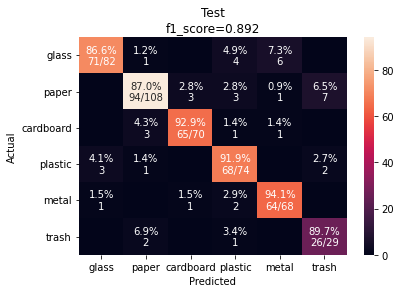

In [ ]:
classes = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']

score_test = f1_score(df_test['label'].astype(int), Y_train_pred, average='macro')
plot_cm(df_test['label'].astype(int), Y_train_pred, 'Test\nf1_score=' + str('%.3f' %score_test), classes)

### 3) ViT (Vision Transformer) 모델

<br>

<img src = "https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png">

attention map을 활용해 지역적인 것뿐 아니라 모든 정보를 활용

+ CNN 모델은 2x2 혹은 3x3 kernel로 데이터를 처리하며 local(지역적인) 영역에서 공간 정보를 찾음

In [ ]:
%%capture
!pip install --quiet vit-keras
!pip install tensorflow-addons

In [ ]:
from vit_keras import vit

vit_model = vit.vit_b32(
        image_size = (256,256),
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 6)

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning:

Resizing position embeddings from 12, 12 to 8, 8



In [ ]:
import tensorflow_addons as tfa


SIZE = 256
input_shape = (SIZE, SIZE, 3)
n_classes = 6

def vit_model():
  
  vit_model = vit.vit_b32(
          image_size = (256,256),
          activation = 'softmax',
          pretrained = True,
          include_top = False,
          pretrained_top = False,
          classes = 6)

  input_tensor = Input(shape=input_shape)
  bn = BatchNormalization()(input_tensor)
  x = vit_model(bn)
  x = Flatten()(x)
  x = BatchNormalization()(x)
  x = Dense(128, activation = tfa.activations.gelu)(x)
  x = BatchNormalization()(x)
  x = Dense(64, activation = tfa.activations.gelu)(x)
  x = BatchNormalization()(x)

  predictions = Dense(n_classes, activation='softmax')(x)
  model = Model(inputs=input_tensor, outputs=predictions)

  return model

In [ ]:
# VIT 모델 구조

vit_model = vit_model()
vit_model.summary()

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 8, 8
  UserWarning,


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 batch_normalization_3 (Batc  (None, 256, 256, 3)      12        
 hNormalization)                                                 
                                                                 
 vit-b32 (Functional)        (None, 768)               87466752  
                                                                 
 flatten_3 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 128)               9843

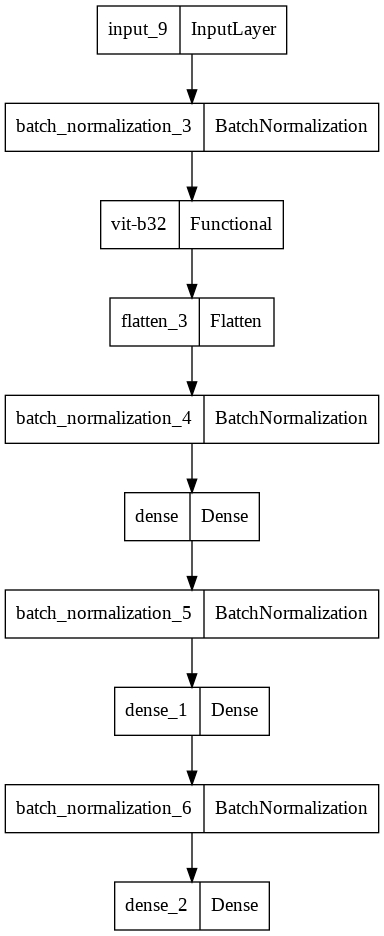

In [ ]:
plot_model(vit_model, to_file='ViT_model.png')

In [ ]:
LR = 1e-4
opt = tfa.optimizers.RectifiedAdam(learning_rate = LR)

vit_model.compile(loss = 'sparse_categorical_crossentropy',
                        optimizer = opt,
                        metrics = ['accuracy'])

callbacks = [EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
            ReduceLROnPlateau(patience=3, verbose=1),
            ModelCheckpoint('/content/drive/MyDrive/__Python Code__/project/vit_model.h5', verbose=1, save_best_only=True)]

In [ ]:
history = vit_model.fit(train_gen,
                        validation_data = valid_gen,
                        epochs = 30, 
                        verbose = 1,
                        class_weight = class_weight,
                        callbacks = callbacks)

Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 0.6554 - accuracy: 0.2472 
Epoch 00001: val_loss improved from inf to 1.76543, saving model to /content/drive/MyDrive/__Python Code__/project/vit_model.h5
56/56 [==============================] - 891s 15s/step - loss: 0.6554 - accuracy: 0.2472 - val_loss: 1.7654 - val_accuracy: 0.2896 - lr: 1.0000e-04
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 0.3925 - accuracy: 0.5226
Epoch 00002: val_loss improved from 1.76543 to 1.33197, saving model to /content/drive/MyDrive/__Python Code__/project/vit_model.h5
56/56 [==============================] - 76s 1s/step - loss: 0.3925 - accuracy: 0.5226 - val_loss: 1.3320 - val_accuracy: 0.5152 - lr: 1.0000e-04
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 0.2660 - accuracy: 0.6923
Epoch 00003: val_loss improved from 1.33197 to 0.98461, saving model to /content/drive/MyDrive/__Python Code__/project/vit_model.h5
56/56 [========================

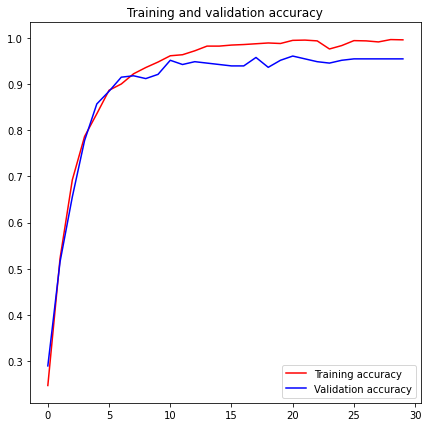

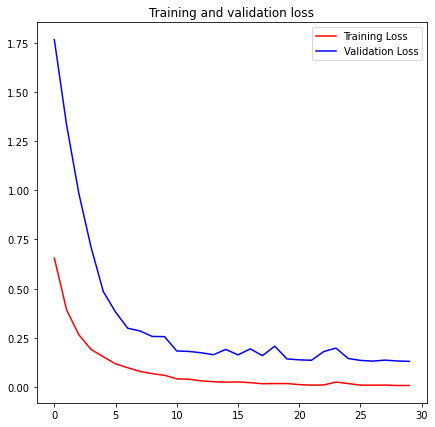

In [ ]:
# 학습 결과 시각화 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(7,7))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(7,7))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

=> overfitting 없이 accuracy가 일정하게 상승하고, loss도 하락

In [ ]:
Y_pred = vit_model.predict(test_gen)
Y_train_pred = np.argmax(Y_pred, axis=1)

confusion matrix와 classification report 결과는 아래와 같습니다.

In [ ]:
# confusion matrix 결과 + classification report 결과
print('     Confusion Matrix ')
print('')
print(confusion_matrix(test_gen.classes, Y_train_pred, labels=np.unique(test_gen.classes)))
print('')
print('\t\t\tClassification Report ')
print('')
print(classification_report(test_gen.classes, Y_train_pred, zero_division=1))

     Confusion Matrix 

[[ 76   1   0   3   2   0]
 [  0 103   2   0   1   2]
 [  0   4  66   0   0   0]
 [  3   1   0  68   2   0]
 [  1   0   0   0  66   1]
 [  0   1   0   1   1  26]]

			Classification Report 

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        82
           1       0.94      0.95      0.94       108
           2       0.97      0.94      0.96        70
           3       0.94      0.92      0.93        74
           4       0.92      0.97      0.94        68
           5       0.90      0.90      0.90        29

    accuracy                           0.94       431
   macro avg       0.94      0.93      0.94       431
weighted avg       0.94      0.94      0.94       431



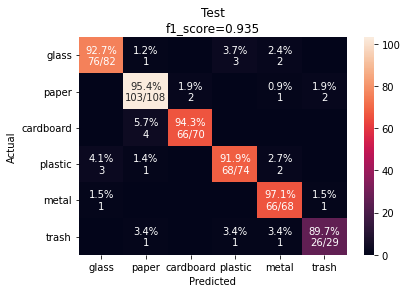

In [ ]:
score_test = f1_score(df_test['label'].astype(int), Y_train_pred, average='macro')
plot_cm(df_test['label'].astype(int), Y_train_pred, 'Test\nf1_score=' + str('%.3f' %score_test), classes)

## Test set에 evaluation했을 때, 결과 비교

### 1) CNN 모델

In [144]:
from keras.models import load_model

basic_cnn_model = load_model('/content/drive/MyDrive/Colab Notebooks/project/basic_cnn_model.h5')
results = basic_cnn_model.evaluate(test_gen, verbose=0)

print("    Loss: {:.4f}".format(results[0]))
print("Accuracy: {:.2f}%".format(results[1] * 100))

    Loss: 0.5724
Accuracy: 80.74%


### 2) EfficientNet 모델

In [ ]:
EfficientNet = load_model('/content/drive/MyDrive/__Python Code__/project/EfficientNet.h5')
results = EfficientNet.evaluate(test_gen, verbose=0)

print("    Loss: {:.4f}".format(results[0]))
print("Accuracy: {:.2f}%".format(results[1] * 100))

    Loss: 0.3029
Accuracy: 90.02%


### 3) ViT(Vision Transformer) 모델

In [ ]:
vit_model = load_model('/content/drive/MyDrive/__Python Code__/project/vit_model.h5')
results = vit_model.evaluate(test_gen, verbose=0)

print("    Loss: {:.4f}".format(results[0]))
print("Accuracy: {:.2f}%".format(results[1] * 100))

    Loss: 0.2210
Accuracy: 93.97%


## 정리

기본 CNN 모델 < EfficientNet 모델 < Vision Transformer 모델 순으로 좋은 결과를 보임

┗ Layer가 깊어질수록 성능이 향상되며, 특히 대용량 데이터셋에 pre-trained한 모델이 성능이 좋다. 

- CNN은 inductive bias가 높지만, Transformer는 inductive bias가 낮다고 합니다. 

  +“inductive bias”: ‘모델이 지금까지 만나보지 못했던 상황에서 정확한 예측을 하기 위해 사용하는 추가적인 가정’
  
   CNN은 “Vision task에서 지역적으로 정보를 얻을 것이 많다”는 가정이 있지만, Transformer는 그렇지 않습니다.

- ViT는 데이터 수가 적은 상황에서 강한 inductive bias를 지닌 모델이 데이터에 대해 가정을 갖고 있기 때문에 약한 inductive bias를 지닌 모델보다 높은 성능을 보인다.
  └ 현재 이 데이터셋에서는 약한 inductive bias를 가진 모델(Transformer)이 inductive bias를 지닌 모델(CNN)보다 높은 성능을 보인다